In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from  datetime import datetime, timedelta


2024-06-11 12:49:59.421788: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 12:49:59.452232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 12:50:00.015139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
start='2010-01-01'
end='2023-12-31'

#Initialiser la date d'aujourd'hui
now=datetime.now()
#Initialiser la date d'aujourd'hui
today = datetime.now().strftime('%Y-%m-%d')

df = yf.download('AAPL', start=start, end=today)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461976,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473148,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370183,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358408,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400682,447610800
...,...,...,...,...,...,...
2024-06-04,194.639999,195.320007,193.029999,194.350006,194.350006,47471400
2024-06-05,195.399994,196.899994,194.869995,195.869995,195.869995,54156800
2024-06-06,195.690002,196.500000,194.169998,194.479996,194.479996,41181800


In [3]:
df=df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461976,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473148,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370183,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358408,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400682,447610800


In [4]:
df=df.drop(['Date','Adj Close'], axis=1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,3633.000000,3633.000000,3633.000000,3633.000000,3.633000e+03
mean,63.584725,64.254573,62.943157,63.625144,2.367270e+08
std,58.405578,59.031404,57.825164,58.453720,2.193377e+08
min,6.870357,7.000000,6.794643,6.858929,2.404830e+07
25%,20.101786,20.274643,19.879286,20.048571,8.900420e+07
50%,35.227501,35.395000,35.014999,35.172501,1.461896e+08
75%,118.720001,120.400002,116.809998,118.690002,3.194756e+08
max,198.020004,199.619995,197.000000,198.110001,1.880998e+09


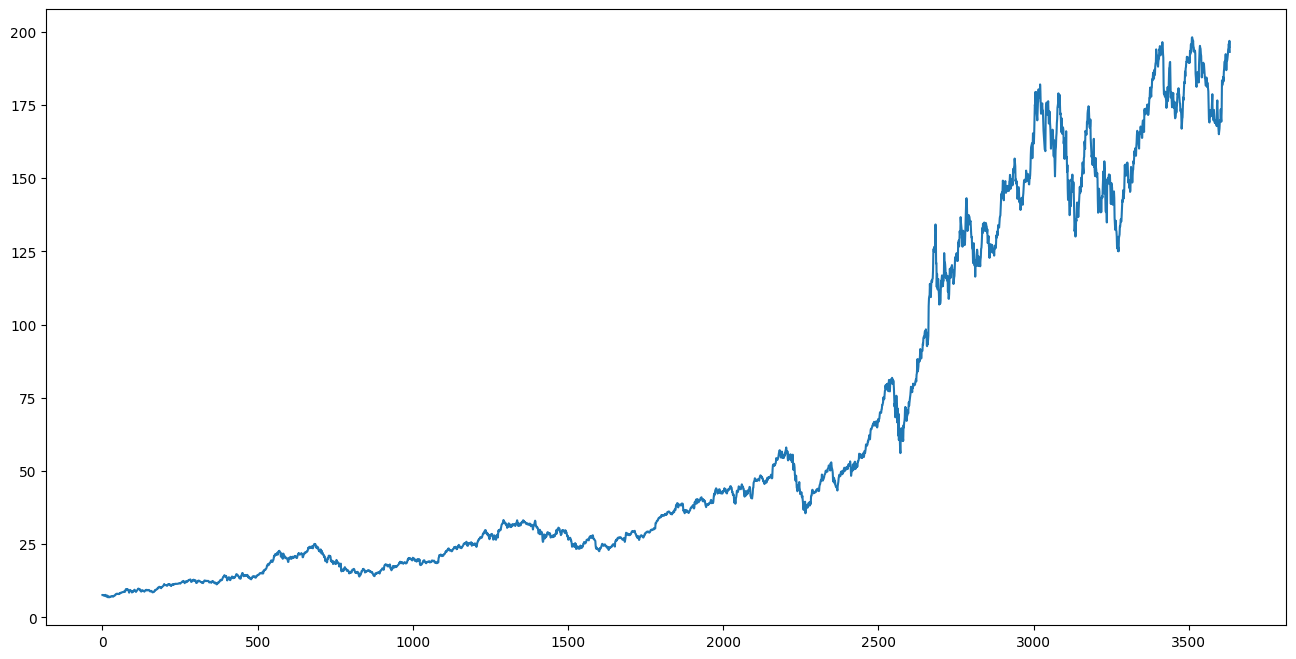

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df.Close)

In [7]:
ma100=df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3628    180.197500
3629    180.300300
3630    180.385900
3631    180.518499
3632    180.622899
Name: Close, Length: 3633, dtype: float64

In [8]:
ma200=df.Close.rolling(200).mean()
ma200

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3628    181.4276
3629    181.5345
3630    181.6277
3631    181.7260
3632    181.7860
Name: Close, Length: 3633, dtype: float64

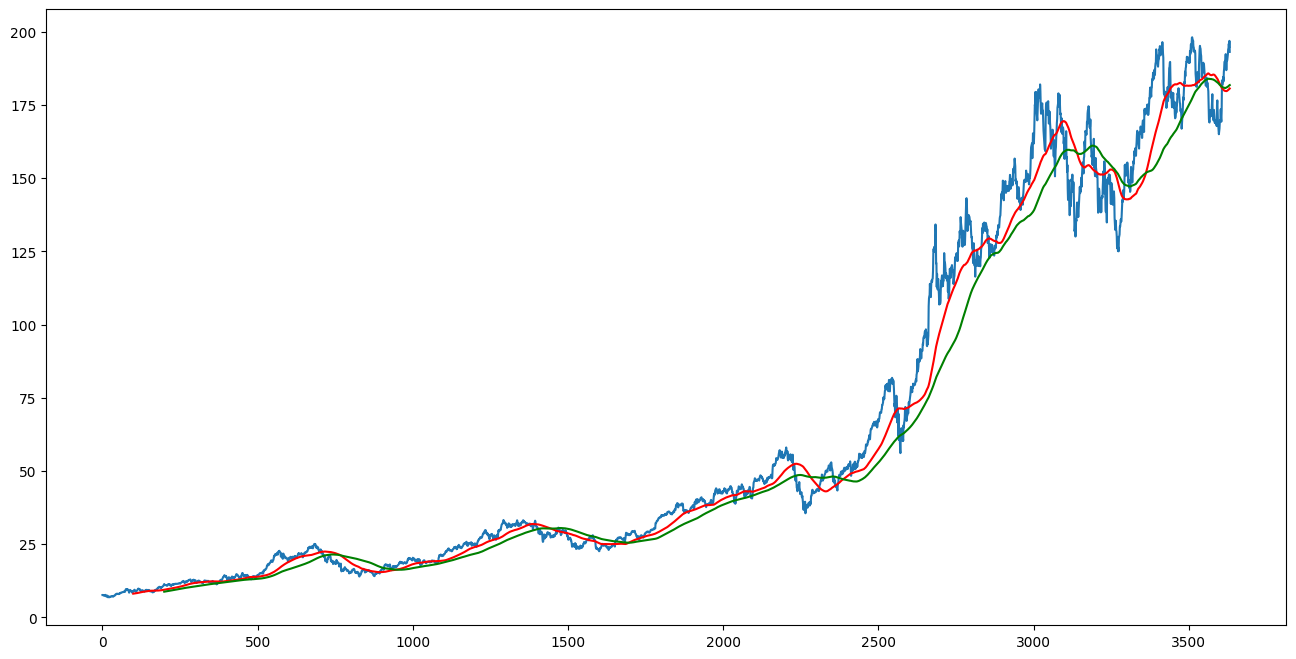

In [9]:
plt.figure(figsize=(16,8))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [10]:
#Division des données en Training (70%) et Testing data (30%)

data_training=pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing=pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

print(data_training.shape)
print(data_testing.shape)
data_training

(2543, 1)
(1090, 1)


,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714
...,...
2538,79.712502
2539,80.362503
2540,81.302498
2541,80.007500


In [11]:
# Sclaling de la Training Data et Transformation en Matrice
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.0105353 ],
       [0.01071281],
       [0.00907686],
       ...,
       [1.        ],
       [0.9826043 ],
       [0.9877088 ]])

In [12]:
#Division de X_train et y_train par pas de 100 jours

x_train=[]
y_train=[]

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])

    

In [13]:
#Conversion de x_train et y_train en matrices
x_train, y_train = np.array(x_train),np.array(y_train)

In [14]:
print(x_train.shape)
print(y_train.shape)

(2443, 100, 1)
(2443,)


In [15]:
data_training_array.shape

(2543, 1)

In [16]:
past_100_days= data_training.tail(100)
data_testing=pd.concat([past_100_days,data_testing], ignore_index=True)
data_testing

,Close
0,55.692501
1,55.240002
2,54.432499
3,54.680000
4,54.419998
...,...
1185,194.350006
1186,195.869995
1187,194.479996
1188,196.889999


In [17]:
data_testing

,Close
0,55.692501
1,55.240002
2,54.432499
3,54.680000
4,54.419998
...,...
1185,194.350006
1186,195.869995
1187,194.479996
1188,196.889999


In [18]:
# Sclaling de la Training Data et Transformation en Matrice
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_testing_array = scaler.fit_transform(data_testing)
data_testing_array.shape

(1190, 1)

In [19]:
#Division de x_test et x_train par pas de 100 jours

x_test=[]
y_test=[]

for i in range(100, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i-100:i])
    y_test.append(data_testing_array[i,0])


In [20]:
#Conversion de x_train et y_train en matrices
x_test, y_test = np.array(x_test),np.array(y_test)


In [21]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
print(x_test.shape)
print(y_test.shape)

(1090, 100, 1)
(1090,)


4) Création du modèle LSTM

In [23]:

# Create the model
model = Sequential()

# First LSTM layer with BatchNormalization and Dropout
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer with increased units
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

# Fourth LSTM layer with increased units
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

# Dense layer
model.add(Dense(units=1))

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for reducing learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(x_train, y_train, epochs=65, batch_size=32, callbacks=[reduce_lr, early_stopping])

# Print the model summary
model.summary()


Epoch 1/65


/home/gblack98/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0973 - learning_rate: 1.0000e-04
Epoch 2/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0097 - learning_rate: 1.0000e-04
Epoch 3/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 4/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0039 - learning_rate: 1.0000e-04
Epoch 5/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 6/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0042 - learning_rate: 1.0000e-04
Epoch 7/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 8/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 9/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 10/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0032 - learning_rate: 1.0000e-04
Epoch 11/65
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0036 - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

5) Enregistrement du modèle

In [34]:
import os
import keras.backend as K
import tensorflow as tf

# Clear Keras backend session
K.clear_session()

# Ensure there are no lingering file handles by deleting the file if it exists
saved_model_dir = '/home/gblack98/prediction_boursière/prediction_boursiere1_saved_model.h5'
if os.path.exists(saved_model_dir):
    os.remove(saved_model_dir)

# Save the model using the native Keras format
model.save(saved_model_dir)

print("Model saved successfully using the native Keras format.")


Model saved successfully using the native Keras format.


6) Evaluation du modèle

In [25]:
print(x_test.shape)
print(y_test.shape)

(1090, 100, 1)
(1090,)


In [26]:
#Prédictions pour x_test
y_pred=model.predict(x_test)
y_pred.shape

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


(1090, 1)

In [27]:
#Récupérer le facteur de scaling
scaler.scale_


array([0.00695943])

In [28]:
#Annuler le scaling
scale_factor=1/scaler.scale_
y_pred=y_pred*scale_factor
y_testing=y_test*scale_factor

In [29]:
y_pred[-1],y_testing[-1]

(array([124.81628912]), 138.6999969482422)

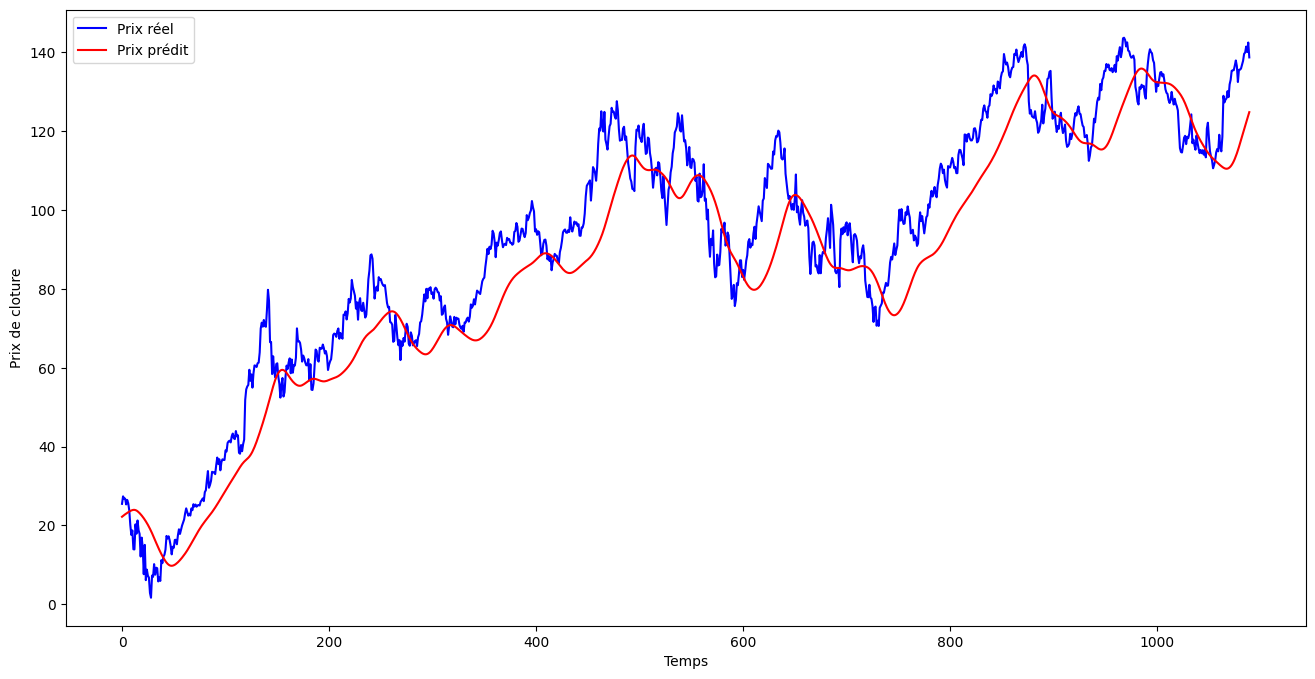

In [30]:
#Visionner la courbe des prédictions du cours de cloture VS le cours du pric de cloture réelle

plt.figure(figsize=(16,8))
plt.plot(y_testing, 'b', label='Prix réel')
plt.plot(y_pred, 'r', label='Prix prédit')
plt.xlabel('Temps')
plt.ylabel('Prix de cloture')
plt.legend()
plt.show()

In [31]:
x=[]
x.append(y_test[-100:])
x=np.array(x)
x = np.expand_dims(x, axis=2)  # Add a new axis to represent the number of features
x.shape

(1, 100, 1)

In [35]:
pred_tomorrow=model.predict(x)
pred_tomorrow.shape
pred_tomorrow

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


array([[0.8745355]], dtype=float32)

In [37]:
pred_tomorrow=pred_tomorrow*scale_factor
print("Le prix de cloture pour aujourd'hui est :", y_testing[-1],"\nLe prix de cloture prédit pour demain est:",pred_tomorrow)

Le prix de cloture pour aujourd'hui est : 138.6999969482422 
Le prix de cloture prédit pour demain est: [[18056.37427572]]
